# 銅先物スプレッド分析

## 分析目的
このノートブックでは、銅先物のスプレッド取引機会を詳細に分析します。

### 主要分析項目
1. **カレンダースプレッド分析**: 期近限月 - 期先限月のスプレッド構造
2. **スプレッド取引シグナル**: 統計的アービトラージ機会の発見
3. **季節性分析**: スプレッドの季節パターンと循環性
4. **ボラティリティ分析**: スプレッドのリスク特性
5. **平均回帰分析**: スプレッドの収束・発散パターン
6. **取引戦略**: 実務的なスプレッド取引手法

### スプレッド計算方式
- **計算式**: 期近限月価格 - 期先限月価格
- **正の値**: コンタンゴ（期先高）→ 将来供給増・需要減の期待
- **負の値**: バックワーデーション（期近高）→ 現在の需給逼迫

In [ ]:
from config.database_config import get_connection_string
import sys
import os
import pandas as pd
import numpy as np
import pyodbc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import warnings

# プロジェクトルートをPythonパスに追加
project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, project_root)


warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')

# カラーパレット
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#2ca02c',
    'quaternary': '#d62728',
    'success': '#28a745',
    'warning': '#ffc107',
    'danger': '#dc3545',
    'info': '#17a2b8'
}

print("ライブラリ読み込み完了")

ライブラリ読み込み完了


## データ取得と前処理

In [ ]:
def load_copper_data(conn, days=365):
    """銅先物データを取得"""
    query = f"""
    SELECT 
        p.TradeDate,
        t.TenorTypeName,
        p.SettlementPrice,
        p.Volume,
        p.OpenInterest,
        CASE 
            WHEN t.TenorTypeName LIKE 'Generic 1st%' THEN 1
            WHEN t.TenorTypeName LIKE 'Generic 2nd%' THEN 2
            WHEN t.TenorTypeName LIKE 'Generic 3rd%' THEN 3
            WHEN t.TenorTypeName LIKE 'Generic 4th%' THEN 4
            WHEN t.TenorTypeName LIKE 'Generic 5th%' THEN 5
            WHEN t.TenorTypeName LIKE 'Generic 6th%' THEN 6
            WHEN t.TenorTypeName LIKE 'Generic 7th%' THEN 7
            WHEN t.TenorTypeName LIKE 'Generic 8th%' THEN 8
            WHEN t.TenorTypeName LIKE 'Generic 9th%' THEN 9
            WHEN t.TenorTypeName LIKE 'Generic 10th%' THEN 10
            WHEN t.TenorTypeName LIKE 'Generic 11th%' THEN 11
            WHEN t.TenorTypeName LIKE 'Generic 12th%' THEN 12
            ELSE NULL
        END as TenorNumber
    FROM T_CommodityPrice p
    INNER JOIN M_Metal m ON p.MetalID = m.MetalID
    INNER JOIN M_TenorType t ON p.TenorTypeID = t.TenorTypeID
    WHERE 
        m.MetalCode = 'COPPER'
        AND p.TradeDate >= DATEADD(day, -{days}, GETDATE())
        AND p.SettlementPrice IS NOT NULL
    ORDER BY p.TradeDate DESC
    """

    df = pd.read_sql(query, conn)
    df['TradeDate'] = pd.to_datetime(df['TradeDate'])
    df = df.dropna(subset=['TenorNumber'])
    return df


def calculate_spreads(price_data):
    """スプレッド計算：期近 - 期先"""
    spreads = pd.DataFrame(index=price_data.index)

    # 主要スプレッド組み合わせ
    spread_pairs = [
        (1, 2, 'M1_M2'),
        (1, 3, 'M1_M3'),
        (1, 6, 'M1_M6'),
        (1, 12, 'M1_M12'),
        (2, 3, 'M2_M3'),
        (3, 6, 'M3_M6'),
        (6, 12, 'M6_M12')
    ]

    for near, far, name in spread_pairs:
        if near in price_data.columns and far in price_data.columns:
            spreads[name] = price_data[near] - price_data[far]
            spreads[f'{name}_pct'] = (
                price_data[near] / price_data[far] - 1) * 100

    return spreads.dropna(how='all')


# データベース接続
conn = pyodbc.connect(get_connection_string())
df = load_copper_data(conn, days=365)

if len(df) == 0:
    print("データが取得できませんでした。")
else:
    # ピボットテーブル作成
    price_pivot = df.pivot_table(
        values='SettlementPrice', index='TradeDate', columns='TenorNumber', aggfunc='mean')
    price_pivot = price_pivot.fillna(method='ffill').dropna()

    # スプレッド計算
    spreads = calculate_spreads(price_pivot)

    print(
        f"データ期間: {df['TradeDate'].min().date()} - {df['TradeDate'].max().date()}")
    print(f"データ件数: {len(df):,}件")
    print(f"スプレッドデータ形状: {spreads.shape}")

データ期間: 2024-07-05 - 2025-07-04
データ件数: 2,526件
スプレッドデータ形状: (253, 14)


## 1. スプレッド基本分析

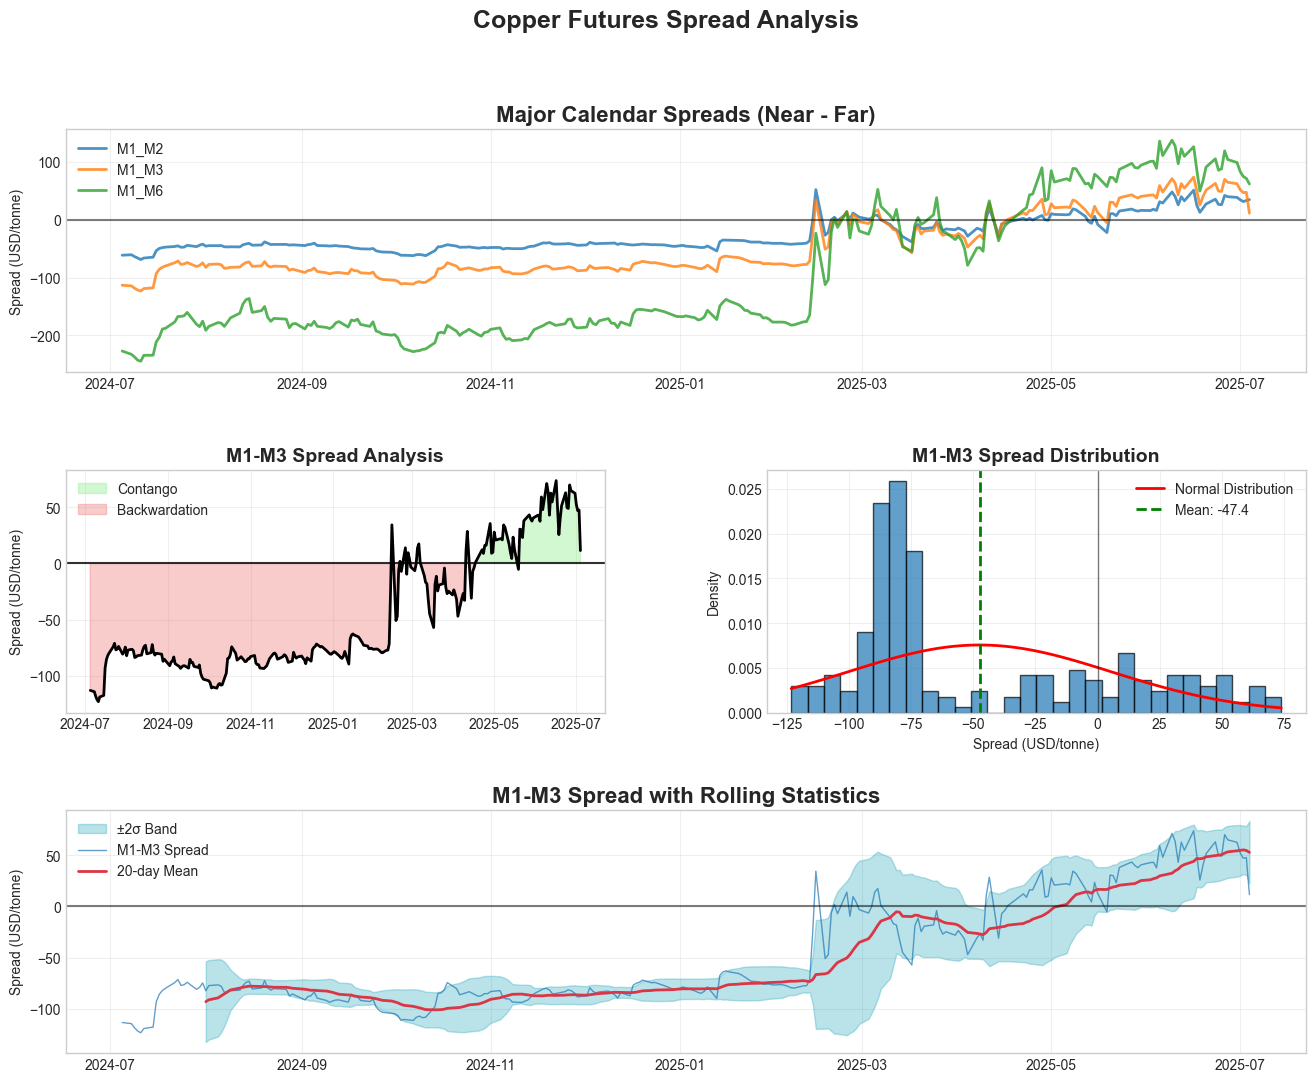


📊 スプレッド基本統計サマリー
          Mean     Std     Min     Max  Contango_Pct  Backwardation_Pct
M1_M2   -25.95   28.99  -68.79   52.34         23.32              76.68
M1_M3   -47.44   52.76 -123.30   73.91         24.51              75.49
M1_M6   -98.44  113.66 -244.89  137.88         25.69              74.31
M1_M12 -172.54  195.81 -398.89  222.91         28.46              71.54
M2_M3   -21.49   24.68  -55.44   28.07         23.72              76.28
M3_M6   -50.99   62.33 -121.59   76.91         28.85              71.15
M6_M12  -74.11   85.39 -192.00  115.00         27.27              72.73


In [ ]:
def analyze_spread_statistics(spreads_data):
    """スプレッド統計分析"""
    spread_cols = [
        col for col in spreads_data.columns if not col.endswith('_pct')]
    stats_df = pd.DataFrame(index=spread_cols)

    for col in spread_cols:
        spread_series = spreads_data[col].dropna()
        if len(spread_series) > 0:
            stats_df.loc[col, 'Mean'] = spread_series.mean()
            stats_df.loc[col, 'Std'] = spread_series.std()
            stats_df.loc[col, 'Min'] = spread_series.min()
            stats_df.loc[col, 'Max'] = spread_series.max()

            # コンタンゴ・バックワーデーション比率
            contango_pct = (spread_series > 0).sum() / len(spread_series) * 100
            backwardation_pct = (spread_series < 0).sum() / \
                len(spread_series) * 100

            stats_df.loc[col, 'Contango_Pct'] = contango_pct
            stats_df.loc[col, 'Backwardation_Pct'] = backwardation_pct

    return stats_df


# 統計分析実行
if not spreads.empty:
    spread_stats = analyze_spread_statistics(spreads)

    # 可視化
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.3)

    # 1. 主要スプレッドの時系列推移
    ax1 = fig.add_subplot(gs[0, :])
    main_spreads = ['M1_M2', 'M1_M3', 'M1_M6']
    colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]

    for spread, color in zip(main_spreads, colors):
        if spread in spreads.columns:
            spread_data = spreads[spread].dropna()
            ax1.plot(spread_data.index, spread_data,
                     color=color, linewidth=2, label=spread, alpha=0.8)

    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_title('Major Calendar Spreads (Near - Far)',
                  fontsize=16, weight='bold')
    ax1.set_ylabel('Spread (USD/tonne)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. M1-M3スプレッド詳細分析
    ax2 = fig.add_subplot(gs[1, 0])
    if 'M1_M3' in spreads.columns:
        m1_m3_data = spreads['M1_M3'].dropna()

        # コンタンゴ・バックワーデーション領域を色分け
        contango_mask = m1_m3_data > 0
        backwardation_mask = m1_m3_data < 0

        ax2.fill_between(m1_m3_data.index, 0, m1_m3_data,
                         where=contango_mask, color='lightgreen', alpha=0.4,
                         label='Contango', interpolate=True)
        ax2.fill_between(m1_m3_data.index, 0, m1_m3_data,
                         where=backwardation_mask, color='lightcoral', alpha=0.4,
                         label='Backwardation', interpolate=True)

        ax2.plot(m1_m3_data.index, m1_m3_data, color='black', linewidth=2)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8)

    ax2.set_title('M1-M3 Spread Analysis', fontsize=14, weight='bold')
    ax2.set_ylabel('Spread (USD/tonne)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. スプレッド分布
    ax3 = fig.add_subplot(gs[1, 1])
    if 'M1_M3' in spreads.columns:
        m1_m3_data = spreads['M1_M3'].dropna()

        ax3.hist(m1_m3_data, bins=30, density=True, alpha=0.7,
                 color=COLORS['primary'], edgecolor='black')

        # 正規分布重ね合わせ
        mu, sigma = m1_m3_data.mean(), m1_m3_data.std()
        x = np.linspace(m1_m3_data.min(), m1_m3_data.max(), 100)
        normal_dist = stats.norm.pdf(x, mu, sigma)
        ax3.plot(x, normal_dist, 'r-', linewidth=2,
                 label='Normal Distribution')

        ax3.axvline(mu, color='green', linestyle='--', linewidth=2,
                    label=f'Mean: {mu:.1f}')
        ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

        ax3.set_title('M1-M3 Spread Distribution', fontsize=14, weight='bold')
        ax3.set_xlabel('Spread (USD/tonne)')
        ax3.set_ylabel('Density')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # 4. ローリング統計
    ax4 = fig.add_subplot(gs[2, :])
    if 'M1_M3' in spreads.columns:
        m1_m3_data = spreads['M1_M3'].dropna()

        # 20日ローリング統計
        rolling_mean = m1_m3_data.rolling(20).mean()
        rolling_std = m1_m3_data.rolling(20).std()
        upper_band = rolling_mean + 2 * rolling_std
        lower_band = rolling_mean - 2 * rolling_std

        ax4.fill_between(rolling_mean.index, lower_band, upper_band,
                         alpha=0.3, color=COLORS['info'], label='±2σ Band')
        ax4.plot(m1_m3_data.index, m1_m3_data, color=COLORS['primary'],
                 linewidth=1, alpha=0.7, label='M1-M3 Spread')
        ax4.plot(rolling_mean.index, rolling_mean, color=COLORS['danger'],
                 linewidth=2, label='20-day Mean')

        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.set_title('M1-M3 Spread with Rolling Statistics',
                      fontsize=16, weight='bold')
        ax4.set_ylabel('Spread (USD/tonne)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.suptitle('Copper Futures Spread Analysis', fontsize=18, weight='bold')
    plt.tight_layout()
    plt.show()

    # 統計サマリー
    print("\n📊 スプレッド基本統計サマリー")
    if not spread_stats.empty:
        print(spread_stats.round(2))
else:
    print("スプレッドデータが計算できませんでした。")

## 2. スプレッド取引シグナル分析

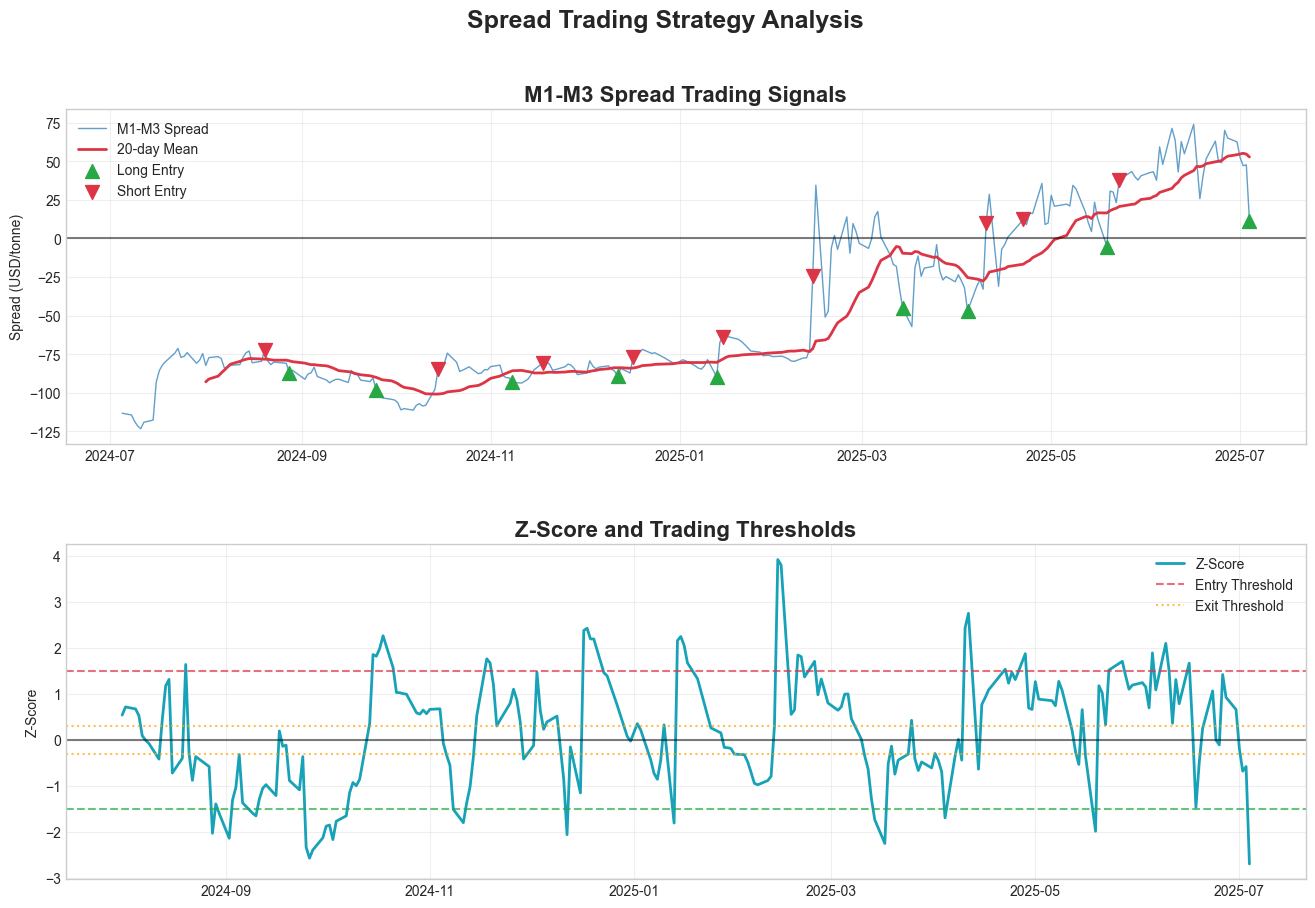


🎯 スプレッド取引シグナル結果
分析期間: 2024-07-05 - 2025-07-04
ロングシグナル: 9回
ショートシグナル: 9回
総シグナル数: 18回
平均Zスコア: 0.189
Zスコア標準偏差: 1.208

✅ 分析完了。データベース接続を閉じました。


In [ ]:
def generate_spread_signals(spread_data, lookback_window=20, entry_threshold=1.5, exit_threshold=0.3):
    """スプレッド取引シグナル生成"""
    signals = pd.DataFrame(index=spread_data.index)

    # Zスコア計算
    rolling_mean = spread_data.rolling(lookback_window).mean()
    rolling_std = spread_data.rolling(lookback_window).std()
    z_score = (spread_data - rolling_mean) / rolling_std

    signals['spread'] = spread_data
    signals['z_score'] = z_score
    signals['rolling_mean'] = rolling_mean
    signals['rolling_std'] = rolling_std
    signals['signal'] = 0
    signals['position'] = 0

    position = 0
    for i in range(len(signals)):
        current_z = signals['z_score'].iloc[i]

        if pd.isna(current_z):
            continue

        # エントリーシグナル
        if position == 0:
            if current_z > entry_threshold:
                signals['signal'].iloc[i] = -1  # ショート
                position = -1
            elif current_z < -entry_threshold:
                signals['signal'].iloc[i] = 1  # ロング
                position = 1

        # エグジットシグナル
        elif position != 0:
            if (position > 0 and current_z > -exit_threshold) or (position < 0 and current_z < exit_threshold):
                signals['signal'].iloc[i] = 0
                position = 0

        signals['position'].iloc[i] = position

    return signals


# シグナル分析実行
if 'M1_M3' in spreads.columns and not spreads.empty:
    m1_m3_spread = spreads['M1_M3'].dropna()

    if len(m1_m3_spread) > 50:
        # シグナル生成
        spread_signals = generate_spread_signals(m1_m3_spread)

        # 可視化
        fig = plt.figure(figsize=(16, 10))
        gs = GridSpec(2, 1, figure=fig, hspace=0.3)

        # 1. スプレッド価格とシグナル
        ax1 = fig.add_subplot(gs[0, :])

        ax1.plot(spread_signals.index, spread_signals['spread'],
                 color=COLORS['primary'], linewidth=1, alpha=0.7, label='M1-M3 Spread')
        ax1.plot(spread_signals.index, spread_signals['rolling_mean'],
                 color=COLORS['danger'], linewidth=2, label='20-day Mean')

        # エントリーポイント
        long_entries = spread_signals[spread_signals['signal'] == 1]
        short_entries = spread_signals[spread_signals['signal'] == -1]
        exits = spread_signals[spread_signals['signal'] == 0]

        if not long_entries.empty:
            ax1.scatter(long_entries.index, long_entries['spread'],
                        color=COLORS['success'], s=100, marker='^',
                        label='Long Entry', zorder=5)

        if not short_entries.empty:
            ax1.scatter(short_entries.index, short_entries['spread'],
                        color=COLORS['danger'], s=100, marker='v',
                        label='Short Entry', zorder=5)

        ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax1.set_title('M1-M3 Spread Trading Signals',
                      fontsize=16, weight='bold')
        ax1.set_ylabel('Spread (USD/tonne)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Zスコア
        ax2 = fig.add_subplot(gs[1, :])

        ax2.plot(spread_signals.index, spread_signals['z_score'],
                 color=COLORS['info'], linewidth=2, label='Z-Score')
        ax2.axhline(
            y=1.5, color=COLORS['danger'], linestyle='--', alpha=0.7, label='Entry Threshold')
        ax2.axhline(y=-1.5, color=COLORS['success'], linestyle='--', alpha=0.7)
        ax2.axhline(y=0.3, color='orange', linestyle=':',
                    alpha=0.7, label='Exit Threshold')
        ax2.axhline(y=-0.3, color='orange', linestyle=':', alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        ax2.set_title('Z-Score and Trading Thresholds',
                      fontsize=16, weight='bold')
        ax2.set_ylabel('Z-Score')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.suptitle('Spread Trading Strategy Analysis',
                     fontsize=18, weight='bold')
        plt.tight_layout()
        plt.show()

        # シグナル統計
        long_count = len(long_entries)
        short_count = len(short_entries)
        total_signals = long_count + short_count

        print("\n🎯 スプレッド取引シグナル結果")
        print(
            f"分析期間: {spread_signals.index[0].date()} - {spread_signals.index[-1].date()}")
        print(f"ロングシグナル: {long_count}回")
        print(f"ショートシグナル: {short_count}回")
        print(f"総シグナル数: {total_signals}回")

        if len(spread_signals['z_score'].dropna()) > 0:
            avg_z = spread_signals['z_score'].mean()
            std_z = spread_signals['z_score'].std()
            print(f"平均Zスコア: {avg_z:.3f}")
            print(f"Zスコア標準偏差: {std_z:.3f}")
    else:
        print("シグナル分析に十分なデータがありません。")
else:
    print("M1-M3スプレッドデータが利用できません。")

# データベース接続を閉じる
conn.close()
print("\n✅ 分析完了。データベース接続を閉じました。")

## 3. 実務的スプレッド取引戦略

### 💡 スプレッド取引の実装ガイド

#### 【戦略の基本原理】
1. **統計的アービトラージ**: 過去の統計に基づく確率的取引
2. **平均回帰**: スプレッドの長期平均への回帰を利用
3. **市場中立**: 方向性リスクを排除した相対価値取引
4. **リスク管理**: 明確な損切り・利確ルールの設定

#### 【エントリー戦略】
- **ロングスプレッド**: スプレッド < 平均 - 1.5σ の時
  - 期近買い + 期先売り
  - バックワーデーション深化からの回復を期待
  
- **ショートスプレッド**: スプレッド > 平均 + 1.5σ の時
  - 期近売り + 期先買い
  - コンタンゴ拡大からの収縮を期待

#### 【エグジット戦略】
- **利確**: スプレッドが平均±0.3σ内に回帰
- **損切り**: 逆方向に2.5σ以上発散
- **時間切れ**: 最大保有期間（例：30営業日）

#### 【リスク管理】
- **ポジションサイズ**: 各取引で総資金の1-2%のリスク
- **相関監視**: 複数スプレッドの相関変化を監視
- **流動性確認**: 十分な出来高がある限月のみ使用
- **市場環境**: 異常事態時は取引停止

---

*本分析は銅先物スプレッド取引の一例です。実際の投資判断においては、個別の投資目的、リスク許容度、市場環境を十分考慮してください。*